In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, SimpleRNN, Dropout, Dense,GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


df = pd.read_csv("ReadySoilDataset_Final.csv")
df = df[df['Region'].isin([2,4,5,7])].reset_index(drop=True)
df.head(10)

,Region,Year,Month,SoilTemperature-10,SoilTemperature-30,SoilTemperature-50,Rainfall,Temperature,Min Temperature,Max Temperature,Humidity,Sunshine,Wind Speed,Surface Pressure,Solar Radiation
0,2,2001,1,17.40,18.81,19.43,0.0,18.38,13.04,25.44,62.68,7.94,2.17,101268.29,199.25
1,2,2001,2,19.88,19.98,20.36,1.0,22.61,16.90,28.56,61.71,7.19,1.98,101039.08,210.73
2,2,2001,3,24.08,23.32,23.17,33.0,26.62,20.73,31.84,55.48,8.75,2.10,100882.56,251.75
3,2,2001,4,27.62,27.02,26.77,46.0,29.06,24.71,32.06,65.63,8.55,2.70,100655.40,257.46
4,2,2001,5,28.54,28.29,28.21,402.0,27.69,24.18,32.09,77.39,6.10,2.37,100234.63,172.32
5,2,2001,6,30.11,29.82,29.64,386.0,28.03,25.55,31.75,83.17,3.51,3.64,99934.18,140.45
6,2,2001,7,30.74,30.53,30.64,202.0,28.83,25.92,31.60,80.26,4.55,3.87,99991.05,169.40
7,2,2001,8,30.99,30.99,30.86,205.0,29.46,25.23,31.50,82.19,5.15,3.01,100129.68,181.66
8,2,2001,9,29.83,29.89,29.95,209.0,28.71,24.34,32.42,82.53,4.65,2.14,100499.17,170.22
9,2,2001,10,28.00,28.29,28.50,177.0,27.63,22.83,31.44,80.45,5.60,1.59,100864.38,167.89


In [2]:
features = df[['Month', 'Temperature', 'Min Temperature',
               'Max Temperature', 
               'Rainfall', 'Surface Pressure']]
target = df['SoilTemperature-50']

In [3]:

# Feature scaling with StandardScaler
feat_scaler = StandardScaler()
X_scaled = feat_scaler.fit_transform(features)

# Target scaling with MinMaxScaler
tgt_scaler = MinMaxScaler()
y_scaled = tgt_scaler.fit_transform(target.values.reshape(-1, 1))
# === 4. Sliding-window sequencing ============================================
def create_sliding_window(X, y, window_size):
    Xs, ys = [], []
    for i in range(len(X) - window_size):
        Xs.append(X[i:i + window_size])
        ys.append(y[i + window_size])
    return np.array(Xs), np.array(ys)

WINDOW = 12  # Define the window size for time-series sequences
X_seq, y_seq = create_sliding_window(X_scaled, y_scaled, WINDOW)

# === 5. Train / val / test split =============================================
X_train, X_tmp, y_train, y_tmp = train_test_split(X_seq, y_seq,
                                                  test_size=0.2,
                                                  random_state=2)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp,
                                                test_size=0.5,
                                                random_state=2)


cnn_lstm_model = Sequential([
    # Conv1D Layer for feature extraction
    Conv1D(filters=64, kernel_size=3, activation='relu', padding='same', input_shape=(X_train.shape[1], X_train.shape[2])),
    MaxPooling1D(pool_size=2),
    # LSTM Layers
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    # Fully connected layers
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

cnn_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 2. SimpleRNN Model Definition
simple_rnn_model = Sequential([
    SimpleRNN(64, activation='tanh', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    SimpleRNN(32, activation='tanh', return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

simple_rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 3. LSTM Model Definition
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# 4. GRU Model Definition
gru_model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# === 5. Callbacks ============================================================
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
lr_sched = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# === 6. Train the models =====================================================
# Train CNN-LSTM
cnn_lstm_history = cnn_lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)

cnn_lstm_loss, cnn_lstm_mae = cnn_lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {cnn_lstm_loss:.4f}")
print(f"Test MAE:       {cnn_lstm_mae:.4f}")

# Train SimpleRNN
simple_rnn_history = simple_rnn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)
simple_rnn_loss, simple_rnn_mae = simple_rnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {simple_rnn_loss:.4f}")
print(f"Test MAE:       {simple_rnn_mae:.4f}")

# Train LSTM
lstm_history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)
lstm_loss, lstm_mae = lstm_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {lstm_loss:.4f}")
print(f"Test MAE:       {lstm_mae:.4f}")

# Train GRU
gru_history = gru_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop, checkpoint, lr_sched],
    verbose=1
)

gru_loss, gru_mae = gru_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {gru_loss:.4f}")
print(f"Test MAE:       {gru_mae:.4f}")
# === 8. Plot the comparison ===================================================
# Create list of model names and their test losses
models = ['CNN-LSTM', 'SimpleRNN', 'LSTM', 'GRU']
test_losses = [cnn_lstm_loss, simple_rnn_loss, lstm_loss, gru_loss]






Epoch 1/100


27/27 [==============================] - 7s 64ms/step - loss: 0.1106 - mae: 0.2704 - val_loss: 0.0403 - val_mae: 0.1717 - lr: 0.0010
Epoch 2/100
11/27 [===========>..................] - ETA: 0s - loss: 0.0460 - mae: 0.1770

C:\Users\HP Laptop 15\tfenv\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 0s 13ms/step - loss: 0.0398 - mae: 0.1630 - val_loss: 0.0171 - val_mae: 0.1097 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0228 - mae: 0.1184 - val_loss: 0.0124 - val_mae: 0.0863 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 0s 12ms/step - loss: 0.0194 - mae: 0.1090 - val_loss: 0.0119 - val_mae: 0.0830 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0219 - mae: 0.1145 - val_loss: 0.0089 - val_mae: 0.0707 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0182 - mae: 0.1059 - val_loss: 0.0088 - val_mae: 0.0690 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 0s 11ms/step - loss: 0.0156 - mae: 0.0975 - val_loss: 0.0091 - val_mae: 0.0745 - lr: 0.0010
Epoch 8/100
27/27 [==============================] - 0s 14ms/step - loss: 0.0160 - mae: 0.0960 - val_loss: 0.0085 - val_mae: 0.0697 - lr: 0.00

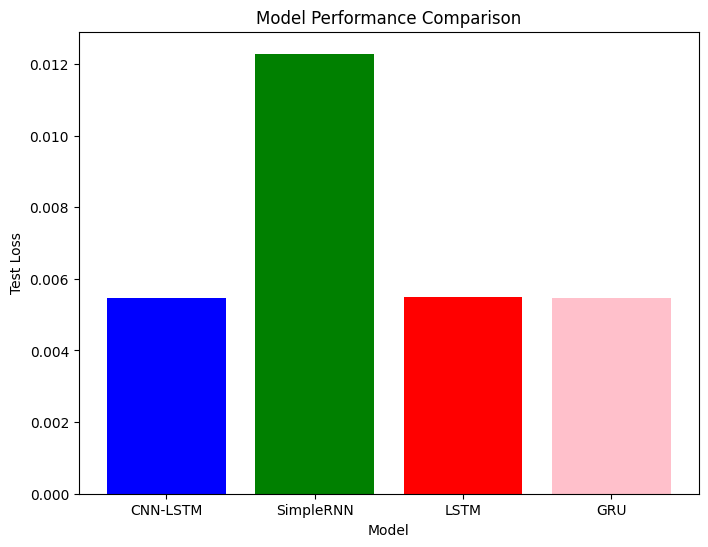

In [17]:
# Plotting
plt.figure(figsize=(8, 6))
plt.bar(models, test_losses, color=['blue', 'green', 'red','pink'])
plt.title('Model Performance Comparison')
plt.xlabel('Model')
plt.ylabel('Test Loss')
plt.show()

In [23]:
print(test_losses)

[0.005388159770518541, 0.011869343928992748, 0.00530689861625433, 0.005558584816753864]
